## Step 1: Import libraries / packages

In [1]:
%reset -f

In [2]:
import cv2
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import platform
import psutil
import subprocess
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [3]:
# Verify that OpenCV is installed correctly
print("OpenCV version:", cv2.__version__)
#Check Python version
print("Python version:", sys.version)
#Check TensorFlow version
print("TensorFlow version:", tf.__version__)
#Check Keras version
print("Keras Version:", tf.keras.__version__)
## Check CUDA version
print("CUDA Version:", tf.sysconfig.get_build_info()['cuda_version'])
# Check cuDNN version
print("cuDNN Version:", tf.sysconfig.get_build_info()['cudnn_version'])
#Get system details
print("System:", platform.system(), platform.version()) 
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    result = subprocess.run(["nvidia-smi", "--query-gpu=name,memory.total,memory.free", "--format=csv,noheader,nounits"], 
                                capture_output=True, text=True)
    gpu_name, total_vram, available_vram = result.stdout.strip().split("\n")[0].split(", ")
    
    print(f"GPU: {gpu_name}")
    print(f"Total VRAM: {float(total_vram) / 1024:.2f} GB")
    print(f"Available VRAM: {float(available_vram) / 1024:.2f} GB")
else:
    print("No GPU detected.")
# Get CPU details
print("Processor:", platform.processor())
# Get RAM info
ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / (1024**3):.2f} GB")
print(f"Available RAM: {ram.available / (1024**3):.2f} GB")

OpenCV version: 4.11.0
Python version: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
TensorFlow version: 2.9.3
Keras Version: 2.9.0
CUDA Version: 64_112
cuDNN Version: 64_8
System: Windows 10.0.26100
GPU: NVIDIA GeForce RTX 5070 Ti
Total VRAM: 15.92 GB
Available VRAM: 14.69 GB
Processor: AMD64 Family 26 Model 68 Stepping 0, AuthenticAMD
Total RAM: 31.16 GB
Available RAM: 18.20 GB


## Step 2: Loading example image

#### Define the path to datasets

In [4]:
# Copy-move datasets
directory_copymove = os.path.expanduser(r"C:\Users\NGSHI\Documents\Dataset\Copy-Move")

# Image file
filename = "0_000000000071.TIF"

# Construct the full path
file_path = os.path.join(directory_copymove,filename)

#### Check if the file exists

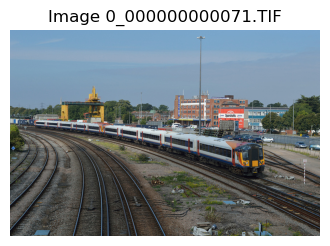

In [5]:
if os.path.exists(file_path):  
    # Load the TIF image using OpenCV  
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # Use IMREAD_UNCHANGED to preserve original format  
    
    if image is not None:  
        # Convert the image from BGR (OpenCV default) to RGB for proper display in matplotlib 
        if len(image.shape) == 3:  # Check if the image has color channels  
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        
        # Display the image using matplotlib  
        plt.figure(figsize=(4, 3))  
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)  
        plt.axis('off')  # Turn off axis  
        plt.title(f"Image {filename}")  
        plt.show()
    else:  
        print("Failed to load the image. The file might not be a valid TIF image.")  
else:  
    print(f"The file '{file_path}' does not exist.")  

## Step 3: Load dataset

In [6]:
# Define paths to the dataset  
copy_move_path = os.path.expanduser(r"C:\Users\NGSHI\Documents\Dataset\Copy-Move")  
inpainting_path = os.path.expanduser(r"C:\Users\NGSHI\Documents\Dataset\Inpainting")
face_path = os.path.expanduser(r"C:\Users\NGSHI\Documents\Dataset\Face") 
splicing_path = os.path.expanduser(r"C:\Users\NGSHI\Documents\Dataset\Splicing") 
real_path = os.path.expanduser(r"C:\Users\NGSHI\Documents\Dataset\Real")
blur_path = os.path.expanduser(r"C:\Users\NGSHI\Documents\Dataset\Blur")

In [7]:
# Function to load the first xxx images from a folder 
pixel = 299
def load_images_from_folder(folder, label, image_size=(pixel, pixel), max_images=2000):  
    images = []  
    labels = []  
    count = 0  
    for filename in os.listdir(folder):  
        if count < max_images: 
            filepath = os.path.join(folder, filename)  
            img = cv2.imread(filepath, cv2.IMREAD_COLOR)  # Load image in color  
            if img is not None:  
                img = cv2.resize(img, image_size)  # Resize image to a fixed size  
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)  
                labels.append(label)  
                count += 1  
    return images, labels  

# Load images
copy_move_images, copy_move_labels = load_images_from_folder(copy_move_path, label=0)  
inpainting_images, inpainting_labels = load_images_from_folder(inpainting_path, label=1)
face_images, face_labels = load_images_from_folder(face_path, label=2)
splicing_images, splicing_labels = load_images_from_folder(splicing_path, label=3)
real_images, real_labels = load_images_from_folder(real_path, label=4)
blur_images, blur_labels = load_images_from_folder(blur_path, label=5)

print(f"Total images in copy-move class: {len(copy_move_images)}")
print(f"Total images in inpainting class: {len(inpainting_images)}")
print(f"Total images in face class: {len(face_images)}")
print(f"Total images in splicing class: {len(splicing_images)}")
print(f"Total images in real image class: {len(real_images)}")
print(f"Total images in blur image class: {len(blur_images)}")

Total images in copy-move class: 2000
Total images in inpainting class: 2000
Total images in face class: 2000
Total images in splicing class: 2000
Total images in real image class: 2000
Total images in blur image class: 2000


In [8]:
# Combine the datasets  
images = np.array(copy_move_images + inpainting_images + face_images + splicing_images +  real_images +  blur_images)  
labels = np.array(copy_move_labels + inpainting_labels + face_labels + splicing_labels +  real_labels +  blur_labels)  

print(f"Total images: {len(images)}, Total labels: {len(labels)}")  

# Get unique labels
unique_labels = tf.unique(labels).y

# List unique labels and count them
print("Unique Labels:", unique_labels.numpy())
print("Number of unique labels:", len(unique_labels.numpy()))

Total images: 12000, Total labels: 12000
Unique Labels: [0 1 2 3 4 5]
Number of unique labels: 6


## Step 4: Pre-processing and  Dataset Preparation

In [9]:
# Normalize the images
images = images.astype(np.float32) / 127.5 - 1  # Normalize the images to [-1, 1]

# Step 1: Split into train+val (80%) and test (20%)
images_trainval, images_test, labels_trainval, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

# Step 2: Split train+val (from above) into train (80%) and val (20%)
images_train, images_val, labels_train, labels_val = train_test_split(
    images_trainval, labels_trainval, test_size=0.2, random_state=42, stratify=labels_trainval)


print("Min pixel value:", images_train.min())
print("Max pixel value:", images_train.max())

print(f"Training set size: {len(images_train)},Validation set size: {len(images_val)}, Testing set size: {len(images_test)}") 

Min pixel value: -1.0
Max pixel value: 1.0
Training set size: 7680,Validation set size: 1920, Testing set size: 2400


## Step 5: Building the Models

#### Load model

In [10]:
# Load Xception without top layers
model_base = Xception(weights=r"C:\Users\NGSHI\Documents\Keras_models\xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
                 include_top=False, input_shape=(pixel, pixel, 3))

# Freeze the first 60 layers
for layer in model_base.layers[:60]:
    layer.trainable = False

# Unfreeze the last 11 layers
for layer in model_base.layers[60:]:
    layer.trainable = True

# Add classification layers
x = GlobalMaxPooling2D()(model_base.output)  # Changed from GlobalAveragePooling2D to GlobalMaxPooling2D
x = BatchNormalization()(x)  # BatchNormalization after pooling

x = Dense(128, kernel_regularizer=l2(0.0005))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)

x = Dense(64, kernel_regularizer=l2(0.0005))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)


# Final output layer for multi-class classification (5 classes)
output = Dense(6, activation='softmax')(x)

# Define the model
model = Model(inputs=model_base.input, outputs=output) 

# Define optimizer
optimizer = Adamax(learning_rate=1e-4)

# Compile model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

#### Train model

In [11]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

datagen = ImageDataGenerator(
    rotation_range=20,             # Randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.2,         # Shift images horizontally (up to 20% of total width)
    height_shift_range=0.2,        # Shift images vertically (up to 20% of total height)
    shear_range=0.1,               # Shear transformation (slanting the image)
    zoom_range=0.1,                # Random zoom in or out (10% range)
    horizontal_flip=True,          # Randomly flip images horizontally
    fill_mode='nearest'            # Fill in missing pixels after transformation using the nearest pixel values
)

#Train model
history = model.fit(
            datagen.flow(images_train, labels_train, batch_size=32),
            epochs=100,
            validation_data=(images_val, labels_val),
            callbacks=[early_stopping, reduce_lr])

Epoch 1/100
240/240 [==============================] - 193s 206ms/step - loss: 2.3474 - accuracy: 0.3251 - val_loss: 1.4591 - val_accuracy: 0.4911 - lr: 1.0000e-04
Epoch 2/100
240/240 [==============================] - 48s 198ms/step - loss: 1.7308 - accuracy: 0.4302 - val_loss: 1.2987 - val_accuracy: 0.5432 - lr: 1.0000e-04
Epoch 3/100
240/240 [==============================] - 47s 196ms/step - loss: 1.5055 - accuracy: 0.4805 - val_loss: 1.2228 - val_accuracy: 0.5729 - lr: 1.0000e-04
Epoch 4/100
240/240 [==============================] - 48s 199ms/step - loss: 1.3557 - accuracy: 0.5201 - val_loss: 1.1610 - val_accuracy: 0.5885 - lr: 1.0000e-04
Epoch 5/100
240/240 [==============================] - 48s 200ms/step - loss: 1.2922 - accuracy: 0.5437 - val_loss: 1.1275 - val_accuracy: 0.6026 - lr: 1.0000e-04
Epoch 6/100
240/240 [==============================] - 47s 197ms/step - loss: 1.2359 - accuracy: 0.5548 - val_loss: 1.0971 - val_accuracy: 0.6083 - lr: 1.0000e-04
Epoch 7/100
240/240 [

## Step 6: Model Evaluation

In [12]:
# Evaluate models on the validation set
acc = model.evaluate(images_test, labels_test,verbose=0)[1]

# Print accuracy
print(f"Test Accuracy: {np.round(acc * 100, 2)}%")

Test Accuracy: 68.17%


## Step 7: Generate predictions

In [13]:
# Get predictions 
predicted_labels = model.predict(images_test,verbose=0)

# Convert the predicted probabilities to class labels (indices)
predicted_class = np.argmax(predicted_labels, axis=1)

## Step 8: Models Performance Visualization

#### Plotting confusion matrix

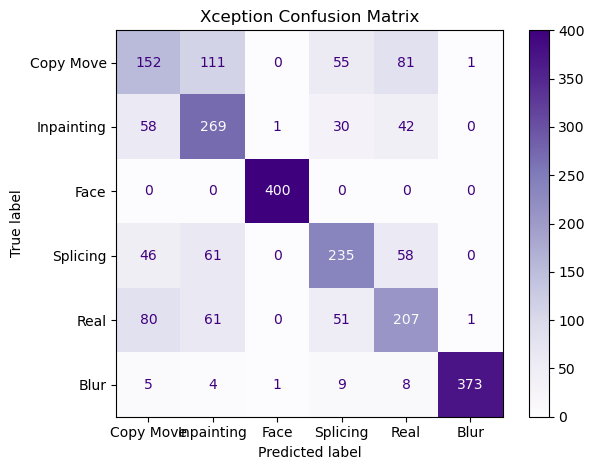

In [14]:
# Define the list of class labels
labels_list = ['Copy Move', 'Inpainting', 'Face', 'Splicing', 'Real', 'Blur']

# Compute confusion matrices
conf_matrix = confusion_matrix(labels_test, predicted_class)

# Create ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_list)

# Xception Confusion Matrix with a custom color map
cm_display.plot(cmap=plt.cm.Purples)
plt.title("Xception Confusion Matrix")

# Adjust layout to avoid overlap and ensure clean plots
plt.tight_layout()

# Show the plot
plt.show()

#### Evaluation metrics

In [15]:
BOLD = "\033[1m"
RESET = "\033[0m"

# Collect results in a dictionary
results = {
    "Xception": np.argmax(model.predict(images_test,verbose=0), axis=1).astype(int)
}

# Print detailed report
print(f"{'Model':<12}{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Support':<10}")
print("=" * 80)

for model_name, preds in results.items():
    print(f"{model_name:<12}")  # Model name only once
    report = classification_report(
        labels_test.astype(int), preds,
        target_names=['Copy Move', 'Inpainting', 'Face', 'Splicing', 'Real', 'Blur'],
        zero_division=1,
        output_dict=True
    )

    for class_name in ['Copy Move', 'Inpainting', 'Face', 'Splicing', 'Real', 'Blur']:
        class_metrics = report[class_name]
        print(f"{'':<12}{class_name:<15}{RESET}{class_metrics['precision']:<10.2f}{class_metrics['recall']:<10.2f}{class_metrics['f1-score']:<10.2f}{class_metrics['support']:<10.0f}")
    
    # Add overall metrics with bold and improved spacing
    print(f"\n{'':<12}{BOLD}{'Accuracy':<15}{RESET}{report['accuracy']:<10.2f}")
    print(f"{'':<12}{BOLD}{'Macro Avg':<15}{RESET}{report['macro avg']['precision']:<10.2f}{report['macro avg']['recall']:<10.2f}{report['macro avg']['f1-score']:<10.2f}")
    print(f"{'':<12}{BOLD}{'Weighted Avg':<15}{RESET}{report['weighted avg']['precision']:<10.2f}{report['weighted avg']['recall']:<10.2f}{report['weighted avg']['f1-score']:<10.2f}")
    print("=" * 80)

Model       Class          Precision Recall    F1-Score  Support   
Xception    
            Copy Move      0.45      0.38      0.41      400       
            Inpainting     0.53      0.67      0.59      400       
            Face           1.00      1.00      1.00      400       
            Splicing       0.62      0.59      0.60      400       
            Real           0.52      0.52      0.52      400       
            Blur           0.99      0.93      0.96      400       

            Accuracy       0.68      
            Macro Avg      0.68      0.68      0.68      
            Weighted Avg   0.68      0.68      0.68      


#### Training history 

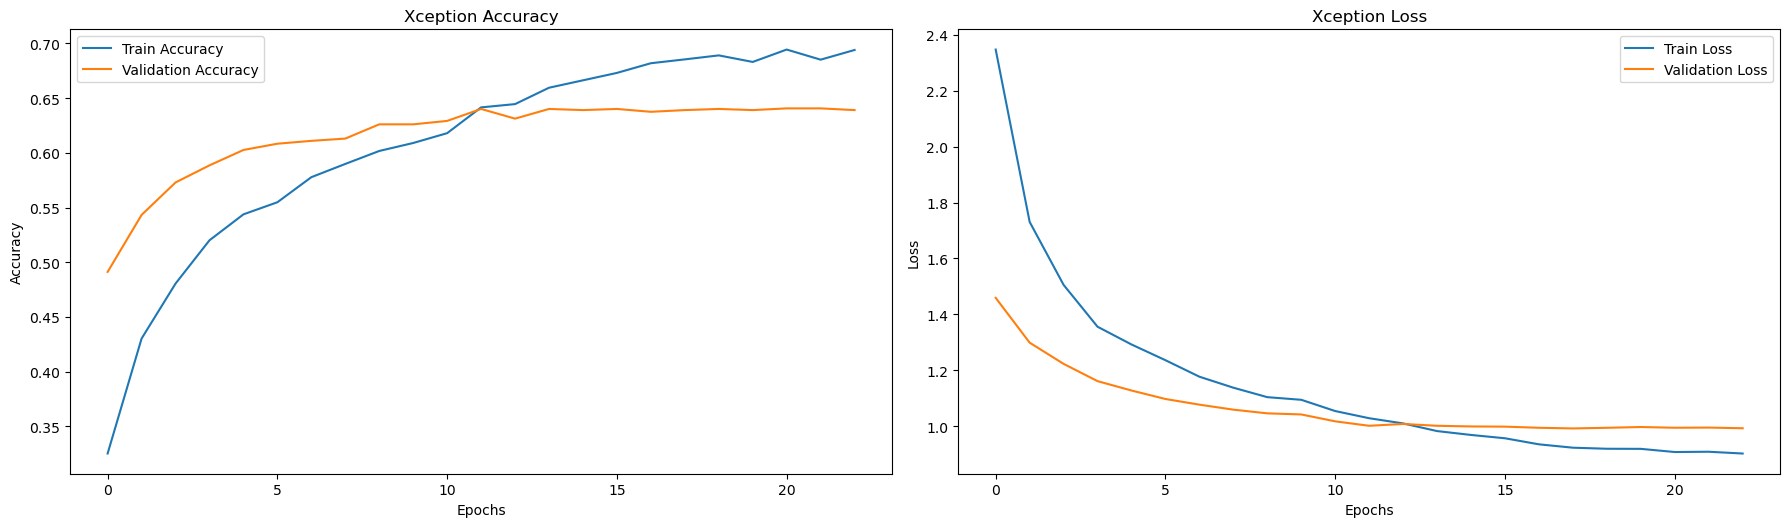

In [16]:
def plot_history(history, model_name, position):
    # Accuracy
    plt.subplot(3, 2, position)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(3, 2, position + 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# Increase the figure size further to ensure visibility of all subplots
plt.figure(figsize=(18, 15))  # Adjusted for better visibility

plot_history(history, "Xception", 1)

plt.tight_layout()  # Ensures no overlap between subplots
plt.show()

#### Sample results

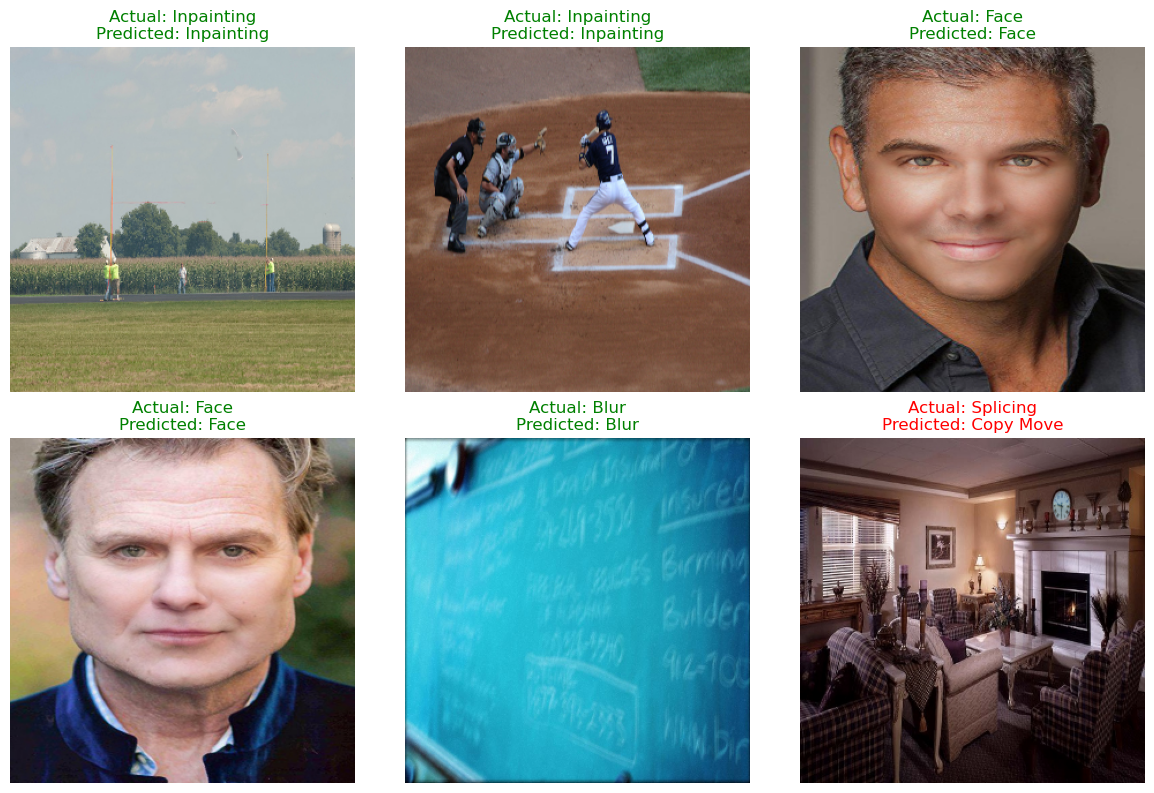

In [17]:
# Encode labels if not already done
encoder = LabelEncoder()
encoder.fit(['Copy Move', 'Inpainting', 'Face', 'Splicing', 'Real', 'Blur'])

# Now, you can use the best model to predict
predicted_labels = model.predict(images_test,verbose=0)  
predicted_label = np.argmax(predicted_labels, axis=1)  # Convert one-hot encoding to class labels (if needed)

labels_test_list = ['Copy Move', 'Inpainting', 'Face', 'Splicing', 'Real', 'Blur']

# For demonstration, display a few test images with their actual and predicted labels
plt.figure(figsize=(12, 8))
for i in range(6):  # Display 6 random images
    idx = random.randint(0, len(images_test) - 1)
    plt.subplot(2, 3, i + 1)
    
    img_to_show = images_test[idx]
    if img_to_show.shape[-1] == 3:  # Check if image has 3 channels (RGB or BGR)
        img_to_show = ((img_to_show + 1) * 127.5).astype(np.uint8)  # Convert float to uint8 if needed

    plt.imshow(img_to_show)
    
    # Get actual and predicted label
    actual_label_number = labels_test[idx]  # Assuming `labels_test` is already encoded as integers
    actual_label = labels_test_list[actual_label_number]
    
    is_correct = actual_label == labels_test_list[predicted_label[idx]]
    
    # Set title color based on correctness
    title_color = 'green' if is_correct else 'red'
    plt.title(f"Actual: {actual_label}\nPredicted: {labels_test_list[predicted_label[idx]]}", color=title_color)
    plt.axis('off')  # Turn off axis
    
plt.tight_layout()
plt.show()

## LIME Explainable AI

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

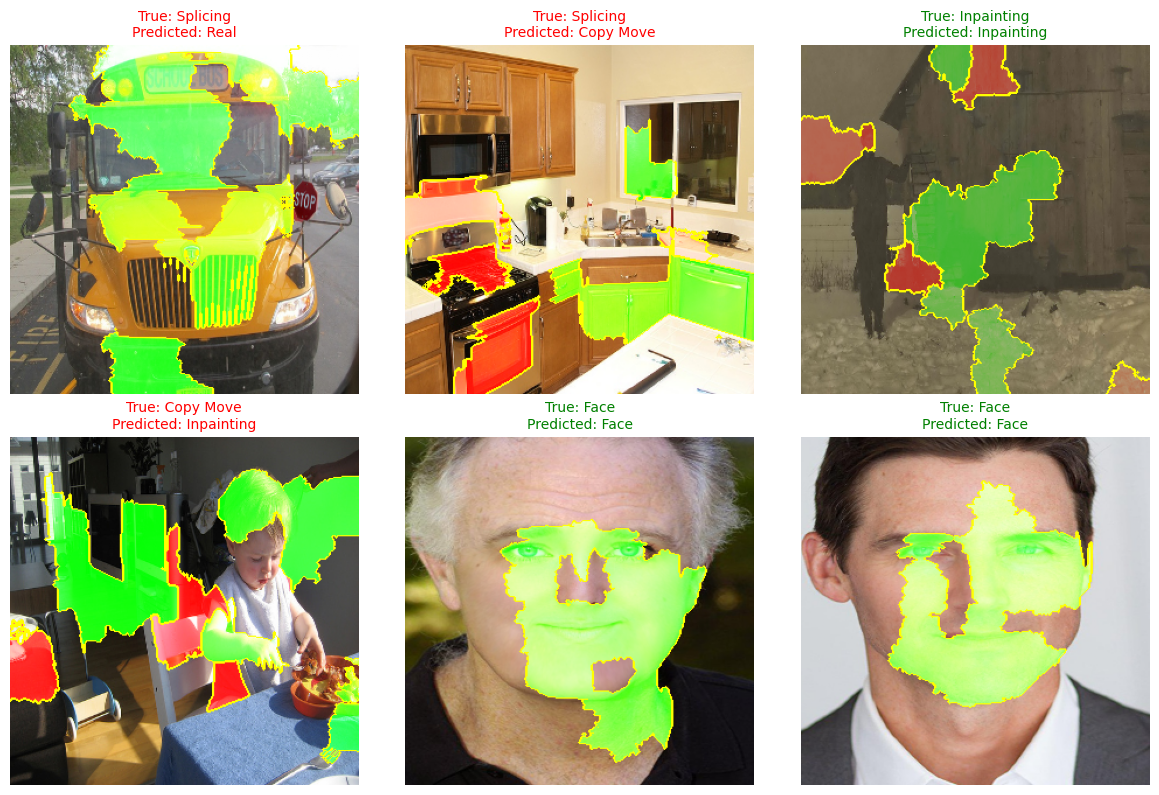

In [18]:
# Class label mapping (update based on your dataset)
class_labels = {0: 'Copy Move', 1: 'Inpainting', 2: 'Face', 3: 'Splicing', 4: 'Real', 5: 'Blur'}

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Function to predict on input images
def predict_fn(images):
    return model.predict(np.array(images),verbose=0)  # No extra normalization

# Number of images to display (adjust as needed)
N = min(6, len(images_train))  # Ensure it doesn't exceed dataset size

# Select N random images
random_indices = random.sample(range(len(images_train)), N)
random_images = images_train[random_indices]
random_labels = labels_train[random_indices]  # Actual labels

# Get model predictions
pred_probs = model.predict(random_images,verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert softmax probabilities to class labels

# Create a grid layout (max 3 per row)
rows = (N // 3) + (N % 3 > 0)  # Calculate rows dynamically
cols = 3  # Set max 3 columns for better visual
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Increase the figsize to utilize more space

# Ensure axes is always a 2D array
if rows == 1:
    axes = np.expand_dims(axes, axis=0)
if cols == 1:
    axes = np.expand_dims(axes, axis=1)

# Flatten for easy indexing
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    # Get the image
    image = random_images[i]

    # Apply LIME to the image
    explanation = explainer.explain_instance(
        image.astype('float32'),
        predict_fn,
        top_labels=5,  # Show top 5 labels
        hide_color=0,
        num_samples=2000  # Reduced number of samples for faster execution
    )

    # Get explanation mask
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    # Convert from [-1, 1] → [0, 1] before displaying
    axes[i].imshow(mark_boundaries((temp + 1) / 2, mask))

    # Get the true and predicted labels
    true_label_name = class_labels[random_labels[i]]
    pred_label_name = class_labels[pred_labels[i]]

    # Check if prediction is correct
    if pred_labels[i] == random_labels[i]:
        title_color = 'green'  # Green for correct prediction
    else:
        title_color = 'red'  # Red for wrong prediction

    # Set the title with the corresponding color
    axes[i].set_title(f"True: {true_label_name}\nPredicted: {pred_label_name}", fontsize=10, color=title_color)
    axes[i].axis("off")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Adjust layout for tighter fitting and to remove unnecessary space
plt.tight_layout(pad=1.0)  # Ensure tight layout without overlap
plt.show()